In [30]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib
from scipy import fftpack as spfft # for computing spectra
import scipy.signal as spsig

import librosa
import resampy
from subprocess import call

%matplotlib inline

# Set plot fontsize
matplotlib.rcParams.update({'font.size': 18})

Direct sonification is simply the process of changing the time scale of a signal to transpose it to the audible range. The data should therefore have similarities with sound waves in air, that is:

 - oscillations around an average value (better if this value is 0), a.k.a "stationary" data. 
 - not a vast range of amplitudes in the thing of interest
 - enough cycles to produce sound at the new frequency. 

We take the example of seismic data... but they could be many other things, e.g.:

[planetary:] 

 - ocean waves, tidal data
 - electro-magnetic waves (solar winds?)
 - gravitational waves
 - planetary orbital positions
 
[biological:] 

 - blood pressure
 - ekg brain waves
 
[sociological:] 
 - stock markets (detrended)?  

# EXAMPLE 1: a large earthquake 


## 1. Get the data (and in to python):

In [31]:
DirIn = '../0_data_nogit/'
DirOut = '../3_output_nogit/'

# (get the data first from the google drive for class-- and put it in the DirIn )
# This is the Tohoku earthquake (2011), recorded by a seimic station located in Central USA
FileNameIn = 'P39A.BHZ' # Note that this data has been pre-processed (instrument response removal)
fs = 20 # Datatype BHZ is sampled at 20 Hz
# In this case, you need to get the info from the data source. ) 

data = np.loadtxt(DirIn + FileNameIn)
duration = len(data)/fs
print('We have ' + str(len(data)) + ' data points at a sampling frequency fs of ' + str(fs))
print('We have ' + str(int(duration)) + ' seconds of data!')
print('... which is ' + str(int(duration/3600)) + ' hours of data!')

# make time vectors for plotting purposes only
t = np.arange(0,duration,1./fs) # in seconds
t_hours = np.arange(0,duration/3600,1./fs/3600) # in hours

We have 1008000 data points at a sampling frequency fs of 20
We have 50400 seconds of data!
... which is 14 hours of data!


In [32]:
# Compute the spectrum

###### some useful prerequisites...

# 1) force the signal's mean value to be zero (how to kill your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# a simple way is to normalize the data according to its maximum amplitude value
# data = data/np.amax(data) # This is dangerous, peak values can be negative, too
# better to do it THIS way:  
data_n = data/np.amax(np.absolute(data))

# Nfft is the number of frequencies to calculate in a discrete signal (i.e. in a computer)
Nfft = len(data_n)
f = np.arange(0,fs/2,fs/Nfft) # to get the actual frequency values
S = spfft.fft(data,Nfft) 
S = S[:int(Nfft/2)] # remove any information from frequencies higher than Nyquist freq (half the number of points)
#https://en.wikipedia.org/wiki/Nyquist_frequency

print('Frequency content ranges from ' + str(f[0]) + ' to ' + str(round(f[-1],3)) + ' Hz...')
print('log Frequency content ranges from ' + str(np.log10(f[1])) + ' to ' + str(np.log10(f[-1])) + ' [log10(Hz)]')

Frequency content ranges from 0.0 to 10.0 Hz...
log Frequency content ranges from -4.70243053645 to 0.999999138304 [log10(Hz)]


/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


(-4.9875520201829886,
 1.2851206220412079,
 -201.9626474925069,
 33.600228556210013)

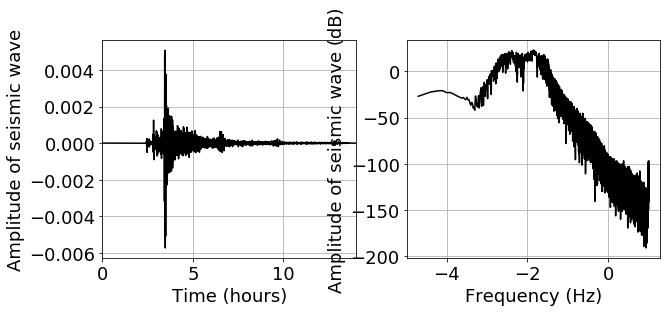

In [33]:
# waveform
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t_hours,data,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
plt.xlim([0,duration/3600])

# spectrum: 
plt.subplot(1,2,2)
#plt.plot(f,20*np.log10(np.absolute(S)),'k') 
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()
plt.axis()

In [36]:
# SPECTROGRAM !
# first compute the short time fourier transform STFT
# "Uncertainty Principle": there is a direct tradeoff between resolution in frequency and in time: 
# that is governed by the window length NfftSTFT

# for the full signal spectra, the Nfft (number of frequencies was simply the length of the signal. 
# instead calculate Nfft upward from the sampling frequency and then window time? 
# 
# or 
duration = len(data)/fs
numwindows = 1000
WindowDur = duration/numwindows


WindowLength = int(WindowDur*fs) # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! 
NfftSTFT = WindowLength*2 # you want the Nyquist frequency to be the window length ! (in number of samples, not seconds)

print('window duration in seconds: ' +str(WindowDur))
print('window length in samples: ' +str(WindowLength))
print(NfftSTFT)

Overlap = int(WindowLength/2) # The overlapping between successive frames (should be expressed in samples)
# This changes the total number of windows, but has to be smaller than the window length (in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_n, fs, nperseg=WindowLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!
print(STFT.shape)
#print(fSTFT.shape)
#print(tSTFT.shape)


window duration in seconds: 50.4
window length in samples: 1008
2016
(1009, 1999)


Text(0,0.5,'dB')

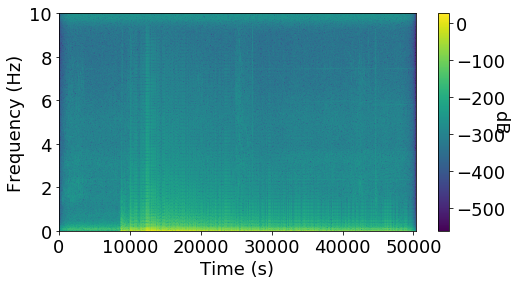

In [37]:
# Let's plot the spectrogram
# notice that the y-axis goes up to half of fs ! i.e. Nyquist frequency
plt.figure(figsize=(8,4))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT))) # dB = 20*log() is a convention
#plt.ylim([0,fs/8])
plt.xlim([0,duration-WindowLength/fs])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [7]:
# Now make a spectrogram with Librosa ! 



## NOW MAKE SOUND !

In [38]:
OutFileName = FileNameIn[:-4] + '_sonified.wav'

# For the free oscillations, we had a specific frequency that we wanted to shift to another one
# Here we can define a target duration instead

OriginalDuration = duration
TargetDuration = 12.0 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# (here we are speeding up the playback because the original content is infrasonic / 
# There are cases where we want to do the opposite, e.g. solar magnetic waves, acoustic emissions during rock microcracking...)
# compute the corresponding shift in frequency
# show the result with subplots original data VS. sonified data 
#      (time series / spectrum / spectrogram = no change except in the time scale)

The data is 50400-s long
Let's make a 12.0-second long sound!
This corresponds to a speed factor of: 4200


In [39]:
# So, set the new sampling rate, and then resample to a standard sampling rate
fs_sound = int(fs*SpeedFactor)
#sr_resample = 44100

librosa.output.write_wav(DirOut + OutFileName, data_n, fs_sound, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound.
#dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=sr_sound)
#data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
#librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)

In [10]:
# # Original vs. Sonified Data
# plt.figure(figsize=(12*2,6*2))
# plt.subplot(1,2,1)
# plt.plot(t_hours,data_n,'k') 
# plt.xlabel('Time (hours)')
# plt.ylabel('Amplitude of seismic wave\n (normalized to max.)')
# plt.grid()
# plt.xlim([0,OriginalDuration/3600])
# plt.title('Old Seismogram (inaudible)')

# plt.subplot(1,2,2)
# plt.plot(t_hours*3600/SpeedFactor,data_n,'k') 
# plt.xlabel('Time (seconds)')
# plt.grid()
# plt.xlim([0,TargetDuration])
# plt.title('New Seismogram (audible)')

# # The difference is only in the time scale. We compress 14 hours into 12 seconds

# =========================================================
# Example 2: Much longer seismic signal: free oscillations 
### filtering to find a hidden signal ! 

#### Their period typically ranges from 20 minutes to a few hours, i.e. a frequency between, say, approximately 0.0002 and 0.002 Hz

### https://vimeo.com/215665951
### http://lucien.saviot.free.fr/terre/index.en.html 

In [42]:
# get the data in: 
DirIn = '../0_data_nogit/'

# This is the Sumatra earthquake (2004), recorded by a seimic station located in Albuquerque, NM
FileNameIn = 'Sumatra_2004_ANMO_14wks.VHZ' 
# Note that this data has been pre-processed (instrument response removal)
fs = 0.1 
# Datatype VHZ is downsampled to 0.1 Hz (p=10 s)

data = np.loadtxt(DirIn + FileNameIn)
duration = len(data)/fs

In [43]:
# make time vectors for plotting purposes only
t = np.arange(0,duration,1./fs) # in seconds
t_hours = np.arange(0,duration/3600,1./fs/3600) # in hours
t_days = np.arange(0,duration/3600/24,1./fs/3600/24) # in days

print('We have ' + str(int(duration)) + ' seconds of data!')
print('... which is ' + str(int(duration/3600)) + ' hours of data!')
print('... which is ' + str(int(duration/3600/24)) + ' days of data!')

We have 8467200 seconds of data!
... which is 2352 hours of data!
... which is 98 days of data!


In [44]:
# Compute the spectrum
Nfft = len(data)
f = np.arange(0,fs/2,fs/Nfft)
S = spfft.fft(data,Nfft); S = S[:int(Nfft/2)]
print('Frequency content ranges from ' + str(f[0]) + ' to ' + str(round(f[-1],3)) + ' Hz...')
print('Frequency content ranges from ' + str(np.log10(f[1])) + ' to ' + str(np.log10(f[-1])) + ' [log10(Hz)]')

Frequency content ranges from 0.0 to 0.05 Hz...
Frequency content ranges from -6.92773981817 to -1.30103102149 [log10(Hz)]


In [45]:
# 1) force the signal's mean value to be zero (how to kill your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# but keep the value because we want to compare the power to other data... 
maxabs = np.amax(np.absolute(data))
data_n = data/maxabs

/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


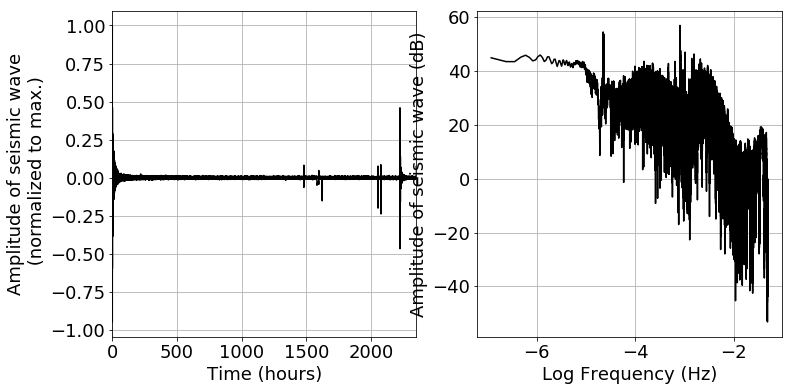

In [46]:
# plot
S = spfft.fft(data_n,Nfft)
S = S[:int(Nfft/2)]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(t_hours,data_n,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave\n (normalized to max.)')
plt.grid()
plt.xlim([0,duration/3600])
plt.subplot(1,2,2)
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Log Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()

(0.0002, 0.002)

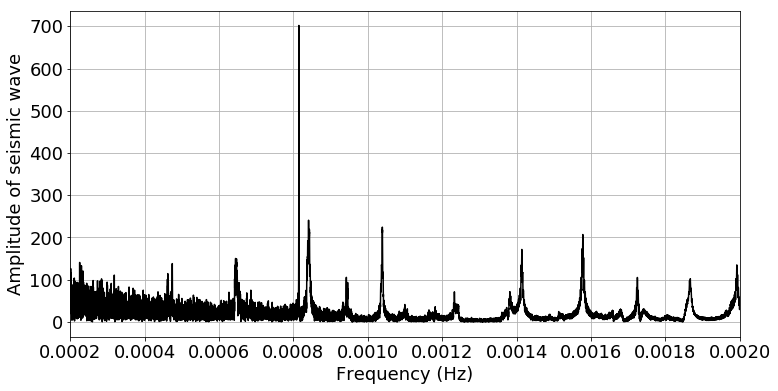

In [16]:
plt.figure(figsize=(12,6))
#plt.plot(np.log10(f),np.log10(np.absolute(S)),'k') 
plt.plot(f,np.absolute(S),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
plt.xlim([0.0002, 0.002])

window duration in seconds: 84672.0
window length in samples: 8467
16934
(8468, 198)


Text(0,0.5,'dB')

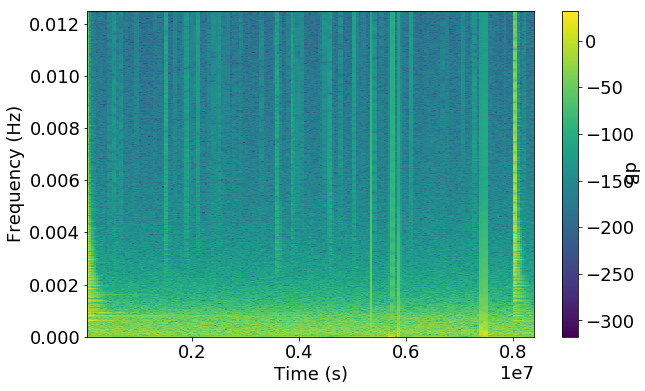

In [47]:
# SPECTROGRAM !
# first compute the short time fourier transform STFT
# "Uncertainty Principle": there is a direct tradeoff between resolution in frequency and in time: 
# that is governed by the window length NfftSTFT

# for the full signal spectra, the Nfft (number of frequencies was simply the length of the signal. 
# instead calculate Nfft upward from the sampling frequency and then window time? 
# 
WindowDur = 300 # in seconds (can calculate this from the lower end of the frequency spectrum that you want to resolve too)
# or 
duration = len(data)/fs
numwindows = 100
WindowDur = duration/numwindows


WindowLength = int(WindowDur*fs) # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! 
NfftSTFT = WindowLength*2 # you want the Nyquist frequency to be the window length ! (in number of samples, not seconds)

print('window duration in seconds: ' +str(WindowDur))
print('window length in samples: ' +str(WindowLength))
print(NfftSTFT)

Overlap = int(WindowLength/2) # The overlapping between successive frames (should be expressed in samples)
# This changes the total number of windows, but has to be smaller than the window length (in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_n, fs, nperseg=WindowLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!
print(STFT.shape)

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [49]:
outfile_name = '14weeks_Sumatra_nofilt.wav'

OriginalDuration = duration
TargetDuration = 24.0 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(fs*SpeedFactor)
# resample at 44.100 kHz
sr_resample = 44100
data_rs = resampy.resample(data_n, sr_sound, sr_resample)
librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound. if so, uncomment: 

# sr_resample = 44100
# dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=sr_sound)
# data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
# librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)

The data is 8467200-s long
Let's make a 24.0-second long sound!
This corresponds to a speed factor of: 352800


(0.0002, 0.002)

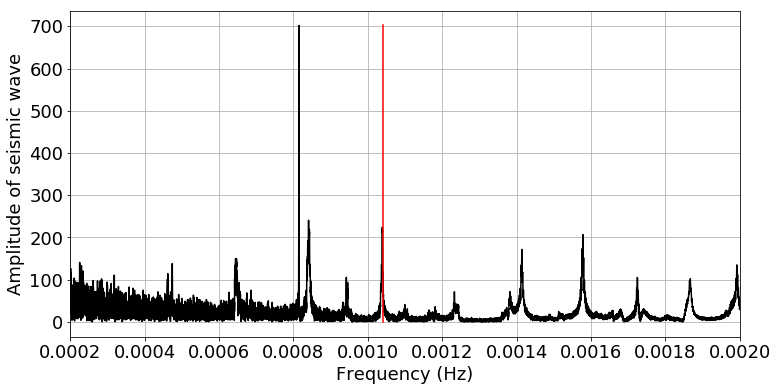

In [52]:
# FILTER AROUND THE MODES ! 

#fcenter = 0.000833333
fcenter = 0.00104
#fcenter = 1/(36*60)

Sabs = np.absolute(S)

plt.figure(figsize=(12,6))
plt.plot(f,Sabs,'k') 
plt.plot([fcenter,fcenter],[0,max(Sabs)],'r-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
plt.xlim([0.0002, 0.002])

In [54]:
Q = 5 # Quality factor: how wide the filter is around fcenter(higher value damps LESS quickly)
FiltOrder = 2; # Filter Order: (how steep the sides are)


BW_SemiWidth = fcenter/(2*Q)
fmin = fcenter-BW_SemiWidth; 
fmax = fcenter+BW_SemiWidth; 
cutofffreq = np.array([fmin, fmax]) / (fs/2);     

b, a = spsig.butter(FiltOrder, cutofffreq, btype='band', analog=False, output='ba')
w, h = spsig.freqz(b, a); 
w = w*fs/np.pi/2

data_filt = spsig.lfilter(b, a, data)
S_filt = spfft.fft(data_filt,Nfft) # compute the spectrum
S_filt = S_filt[:int(Nfft/2)] # up to the Nyquist frequency

print("Center frequency is: " + "%.02E" %(fcenter) + " Hz")
print("Cut-off frequencies are: " + "%.02E" %(fmin) + " Hz & " + "%.02E" %(fmax) + " Hz")

Center frequency is: 1.04E-03 Hz
Cut-off frequencies are: 9.36E-04 Hz & 1.14E-03 Hz


/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


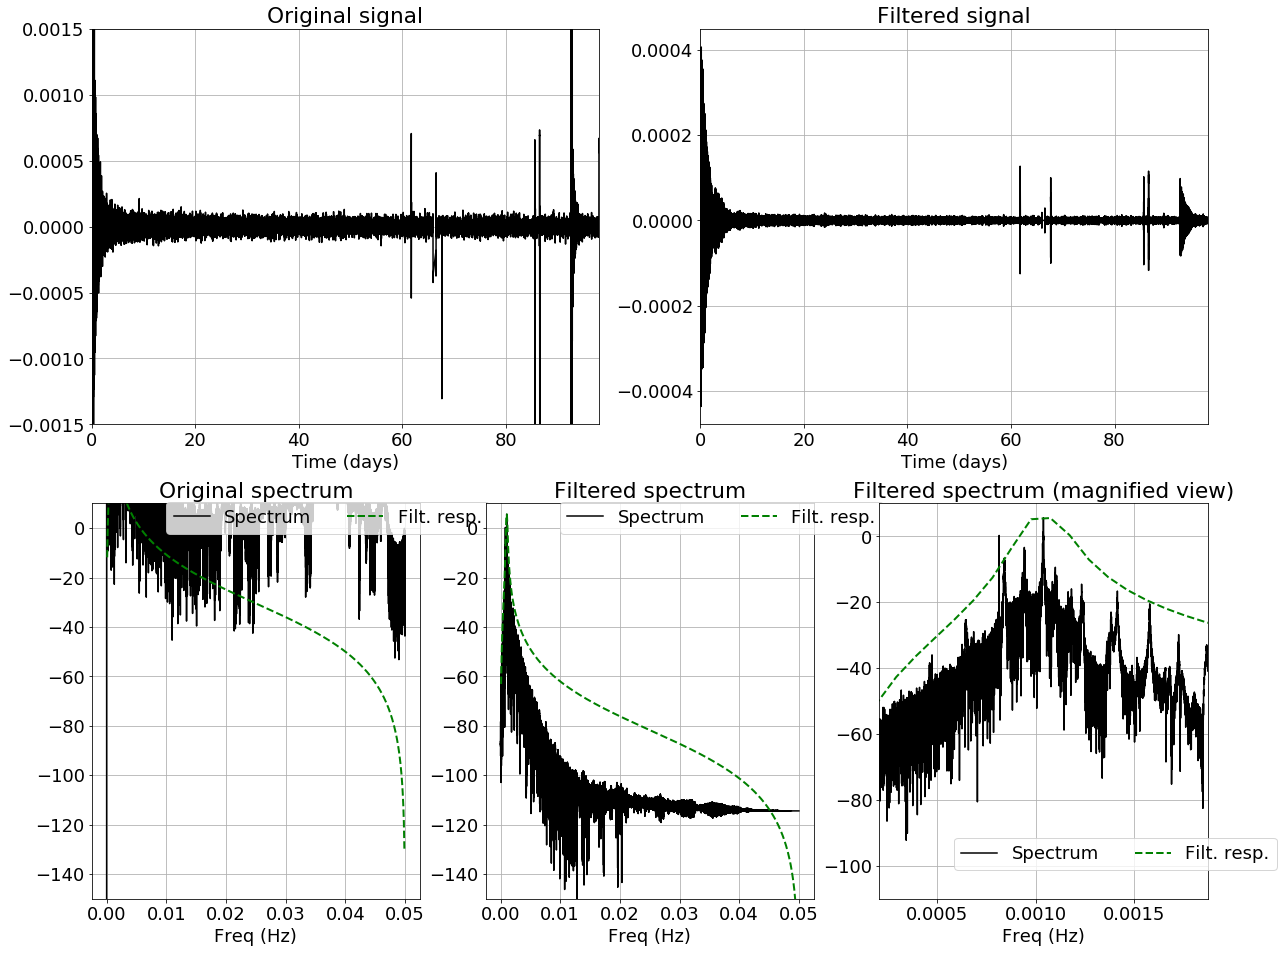

In [55]:
##### Plot and compare original and filtered signals
fig = plt.figure(figsize=(20,16))
plt.subplot(2,2,1)
plt.plot(t_days,data,'k') 
plt.title("Original signal"); plt.xlabel("Time (days)")
plt.ylim([-0.0015, 0.0015])
plt.grid()
plt.xlim([0, duration/3600/24])

plt.subplot(2,2,2)
plt.plot(t_days,data_filt,'k')
plt.title("Filtered signal"); plt.xlabel("Time (days)")
plt.grid()
plt.xlim([0, duration/3600/24])

plt.subplot(2,3,4)
plt.plot(f,20*np.log10(np.abs(S)),'k',label='Spectrum')
plt.plot(w, 20*np.log10(abs(h))+  + 20*np.log10(np.amax(np.abs(S))),'--g',label='Filt. resp.',linewidth=2)
plt.title("Original spectrum"); plt.xlabel("Freq (Hz)")
plt.ylim([-150., 10.])
plt.grid()
plt.legend(bbox_to_anchor=(0.2, 0.9), loc=3,ncol=2)

plt.subplot(2,3,5)
plt.plot(f,20*np.log10(np.abs(S_filt)),'k',label='Spectrum')
plt.plot(w, 20 * np.log10(abs(h)) + 20*np.log10(np.amax(np.abs(S_filt))),'--g',label='Filt. resp.',linewidth=2)
plt.title("Filtered spectrum"); plt.xlabel("Freq (Hz)")
plt.ylim([-150., 10.])
plt.grid()
plt.legend(bbox_to_anchor=(0.2, 0.9), loc=3,ncol=2)

plt.subplot(2,3,6)
plt.plot(f,20*np.log10(np.abs(S_filt)),'k',label='Spectrum')
plt.plot(w, 20*np.log10(abs(h)) + 20*np.log10(np.amax(np.abs(S_filt))),'--g',label='Filt. resp.',linewidth=2)
plt.xlim([fcenter-8*BW_SemiWidth, fcenter+8*BW_SemiWidth])
plt.title("Filtered spectrum (magnified view)"); plt.xlabel("Freq (Hz)")
plt.ylim([-110., 10.])
plt.grid()
plt.legend(bbox_to_anchor=(0.2, 0.05), loc=3,ncol=2)

# want to save this awesome figure?
#fig.savefig(DirOut + 'SumatraFiltered.png')

window duration in seconds: 84672.0
window length in samples: 8467
16934
(8468, 198)


Text(0,0.5,'dB')

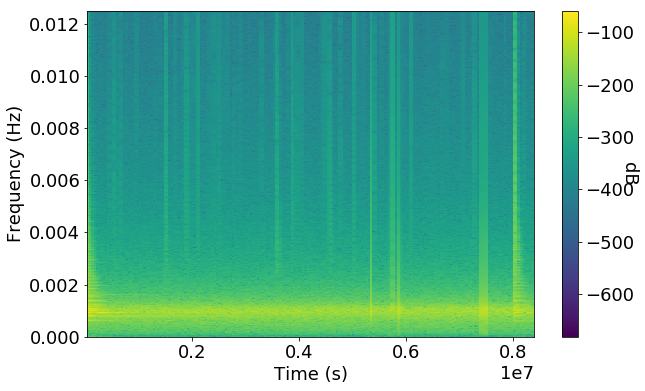

In [56]:
# SPECTROGRAM !

duration = len(data_filt)/fs
numwindows = 100
WindowDur = duration/numwindows


WindowLength = int(WindowDur*fs) # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! 
NfftSTFT = WindowLength*2 # you want the Nyquist frequency to be the window length ! (in number of samples, not seconds)

print('window duration in seconds: ' +str(WindowDur))
print('window length in samples: ' +str(WindowLength))
print(NfftSTFT)

# probably no need to change this. 
Overlap = int(WindowLength/2) # The overlapping between successive frames (should be expressed in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_filt, fs, nperseg=WindowLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!
print(STFT.shape)

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [60]:
# MAKE THE FILTERED SOUND ! 

outfile_name = '14weeks_Sumatra_filt00104.wav'

OriginalDuration = duration
TargetDuration = 14.0 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(fs*SpeedFactor)
# resample at 44.100 kHz
sr_resample = 44100
data_rs = resampy.resample(data_n, sr_sound, sr_resample)
librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

The data is 8467200-s long
Let's make a 14.0-second long sound!
This corresponds to a speed factor of: 604800


## EXERCISE: Go back and filter it on different modes (change the file name to tell you the mode), 
### play with the speed factor and build a composite sound of several modes, using Audacity.  

# =========================================================
# Example 3: LIGO data   
## Laser Interferometer Gravitational-Wave Observatory  (DOI: 10.1103/PhysRevLett.116.061102)
## https://www.ligo.org/
### Much, much much lower amplitude than seismic waves: compare the spectra !
### (too short for direct sonification !)  

In [62]:
# get the data in: 
DirIn = '../0_data_examples/LIGO/'

# This is the Sumatra earthquake (2004), recorded by a seimic station located in Albuquerque, NM
FileNameIn = 'obs_HanfordWA.txt' 
# https://www.gw-openscience.org/GWTC-1-confident/

data = np.loadtxt(DirIn + FileNameIn)
print(data.shape)
print(data[0,0])
# note that np.loadtext automatically skipped the column headers ! 

time = np.squeeze(data[0:-1,0])
strain = np.squeeze(data[0:-1,1])
print(time.shape)

print(time[-1])
#plt.plot(time-time[0])

duration0 = (time[-1]-time[0])
dt = duration0/len(time) # since we don't a priori know if time is regularly spaced (probably is)
print(duration0)

fs = 1/dt 
print(fs)

#duration = len(data)/fs
#print(duration)

(3441, 2)
0.25
(3440,)
0.459899902344
0.209899902344
16388.7641756


In [64]:
# play it directly ! 
data = strain 

# Compute the spectrum
Nfft = len(data)
#f = np.arange(0,sr/2,sr/Nfft)
f = np.linspace(0,fs/Nfft,round(Nfft/2))
S = spfft.fft(data,Nfft) 
S = S[:int(Nfft/2)]
print(len(f))
print(len(S))
print('Frequency content ranges from ' + str(f[0]) + ' to ' + str(round(f[-1],3)) + ' Hz...')
print('Frequency content ranges from [log10] ' + str(np.log10(f[1])) + ' to ' + str(np.log10(f[-1])) + ' Hz...')

1720
1720
Frequency content ranges from 0.0 to 4.764 Hz...
Frequency content ranges from [log10] -2.55728811321 to 0.677987763474 Hz...


/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


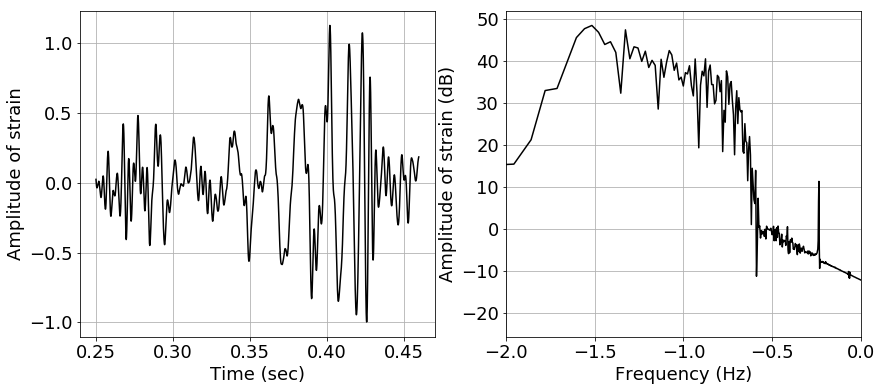

In [65]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(time,data,'k') 
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude of strain')
plt.grid()


plt.subplot(1,2,2)
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of strain (dB)')
plt.xlim([-2,0])
plt.grid()

16388.7641756
window duration in seconds: 0.0104949951172
window length in samples: 172
344
(173, 39)


Text(0,0.5,'dB')

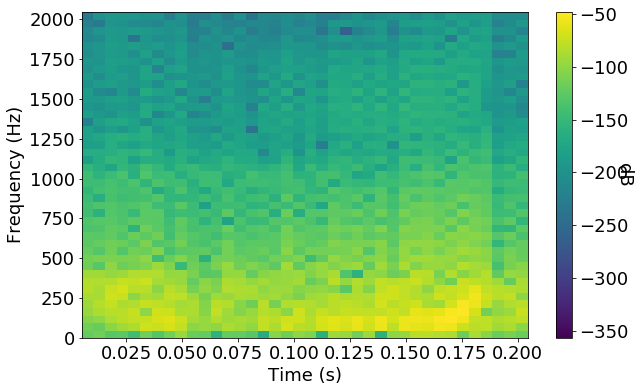

In [67]:
# SPECTROGRAM !
print(fs)
duration = len(data)/fs
numwindows = 20
WindowDur = duration/numwindows


WindowLength = int(WindowDur*fs) # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! 
NfftSTFT = WindowLength*2 # you want the Nyquist frequency to be the window length ! (in number of samples, not seconds)

print('window duration in seconds: ' +str(WindowDur))
print('window length in samples: ' +str(WindowLength))
print(NfftSTFT)

# probably no need to change this. 
Overlap = int(WindowLength/2) # The overlapping between successive frames (should be expressed in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(data, fs, nperseg=WindowLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!
print(STFT.shape)

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [71]:
# MAKE THE FILTERED SOUND ! 

outfile_name = 'LIGO_WA_nofilt.wav'

OriginalDuration = duration
TargetDuration = duration/2 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(OriginalDuration) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(SpeedFactor))

# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(fs*SpeedFactor)
# resample at 44.100 kHz
sr_resample = 44100
data_rs = resampy.resample(data, sr_sound, sr_resample)
librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

The data is 0.209899902344-s long
Let's make a 0.104949951172-second long sound!
This corresponds to a speed factor of: 2.0


## There is not enough data for direct sonification ! 
## We must use other means ! 